<a href="https://colab.research.google.com/github/alexandrulascu/Cresa---WPF-application/blob/master/Tema2_3_SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

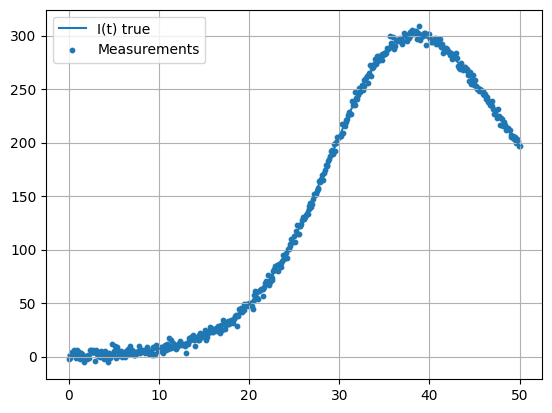

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Model SIR
def sir_rhs(t, y, params):
    S, I, R = y
    beta = params["beta"]
    gamma = params["gamma"]
    N = params["N"]

    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return np.array([dSdt, dIdt, dRdt])

# RK4 integrator
def rk4_step(f, t, y, h, params):
    k1 = f(t, y, params)
    k2 = f(t + h/2, y + h*k1/2, params)
    k3 = f(t + h/2, y + h*k2/2, params)
    k4 = f(t + h, y + h*k3, params)
    return y + h*(k1 + 2*k2 + 2*k3 + k4)/6

def solve_sir(t0, t_end, y0, h, params):
    n = int((t_end - t0)/h)
    t = np.linspace(t0, t_end, n+1)
    y = np.zeros((n+1, 3))
    y[0] = y0
    for i in range(n):
        y[i+1] = rk4_step(sir_rhs, t[i], y[i], h, params)
    return t, y


true_params = {"beta": 0.30, "gamma": 0.1, "N": 1000}
y0 = np.array([999, 1, 0])
t, y = solve_sir(0, 50, y0, 0.1, true_params)

I_true = y[:,1]

noise = np.random.normal(0, 3, size=I_true.shape)
I_measured = I_true + noise

plt.plot(t, I_true, label="I(t) true")
plt.scatter(t, I_measured, s=10, label="Measurements")
plt.legend()
plt.grid(); plt.show()


In [2]:
def simulate_I(beta_guess):
    params = {"beta": beta_guess, "gamma": 0.1, "N": 1000}
    _, y = solve_sir(0, 50, y0, 0.1, params)
    return y[:,1]

def cost(beta_guess):
    I_sim = simulate_I(beta_guess)
    return np.sum((I_sim - I_measured)**2)

betas = np.linspace(0.1, 0.6, 50)
errors = [cost(b) for b in betas]

beta_est = betas[np.argmin(errors)]
beta_est


np.float64(0.3040816326530612)

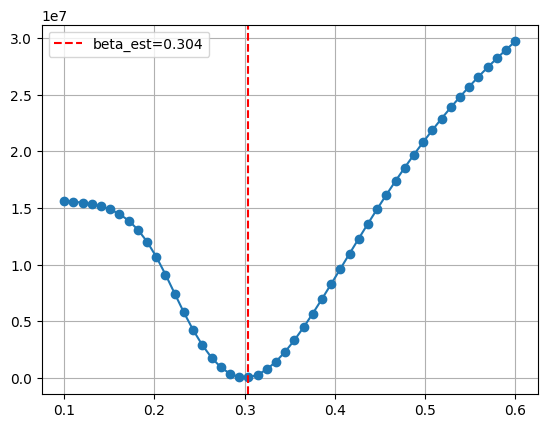

In [3]:
plt.plot(betas, errors, '-o')
plt.axvline(beta_est, color='red', linestyle='--', label=f"beta_est={beta_est:.3f}")
plt.legend(); plt.grid(); plt.show()


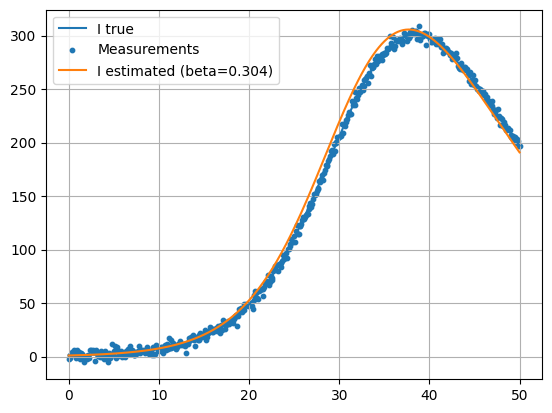

In [4]:
I_est = simulate_I(beta_est)

plt.plot(t, I_true, label="I true")
plt.scatter(t, I_measured, s=10, label="Measurements")
plt.plot(t, I_est, label=f"I estimated (beta={beta_est:.3f})")
plt.legend()
plt.grid()
plt.show()


In [5]:
def estimate_beta_with_samples(k):
    idx = np.linspace(0, len(t)-1, k, dtype=int)
    I_sample = I_measured[idx]

    def cost_sub(beta_guess):
        I_sim = simulate_I(beta_guess)[idx]
        return np.sum((I_sim - I_sample)**2)

    errs = [cost_sub(b) for b in betas]
    return betas[np.argmin(errs)]

for k in [5, 10, 20, 100, 501]:
    print(f"k={k:4d}  -> beta_est={estimate_beta_with_samples(k):.3f}")


k=   5  -> beta_est=0.304
k=  10  -> beta_est=0.304
k=  20  -> beta_est=0.304
k= 100  -> beta_est=0.304
k= 501  -> beta_est=0.304


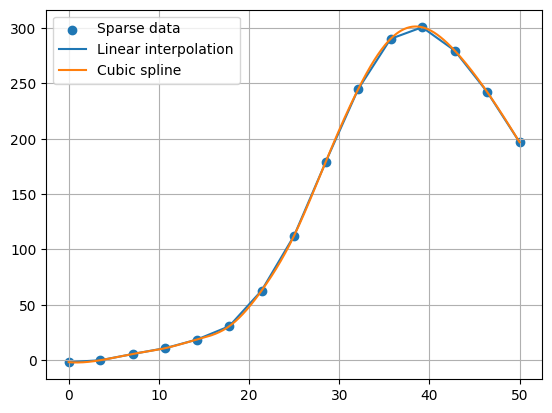

In [6]:
from scipy.interpolate import interp1d, CubicSpline

idx = np.linspace(0, len(t)-1, 15, dtype=int)
t_sparse = t[idx]
I_sparse = I_measured[idx]

lin_interp = interp1d(t_sparse, I_sparse, kind='linear', fill_value="extrapolate")
spline_interp = CubicSpline(t_sparse, I_sparse)

plt.scatter(t_sparse, I_sparse, label="Sparse data")
plt.plot(t, lin_interp(t), label="Linear interpolation")
plt.plot(t, spline_interp(t), label="Cubic spline")
plt.legend(); plt.grid(); plt.show()


In [7]:
beta0_prior = 0.25
lambda_reg = 10.0
def cost_reg(beta_guess):
    I_sim = simulate_I(beta_guess)
    data_term = np.sum((I_sim - I_measured)**2)
    reg_term = lambda_reg * (beta_guess - beta0_prior)**2
    return data_term + reg_term

errors_reg = [cost_reg(b) for b in betas]
beta_est_reg = betas[np.argmin(errors_reg)]

beta_est, beta_est_reg


(np.float64(0.3040816326530612), np.float64(0.3040816326530612))